# Prep: 

In [1]:
from google.colab import drive
drive.mount('/ME')

Drive already mounted at /ME; to attempt to forcibly remount, call drive.mount("/ME", force_remount=True).


In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
datadir='/ME/My Drive/LSDA_data/'
print(torch.__version__)
torch.cuda.is_available()

1.5.0+cu101


True

# Get Mnist data and split into train validation and test

In [0]:
def get_mnist():
    data=np.float64(np.load(datadir+'mnist/MNIST.npy'))
    labels=np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:50000])
    val_dat=data[50000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[50000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

# Get the data 

In [0]:
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    if (data_set=="cifar"):
        return(get_cifar())

# The network

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net, self).__init__()
        # 32 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 64 x 4 x 4 = 1024 units total in final spartial layer fully connected to 256 unit later
        self.fc1 = nn.Linear(1024, 256)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(256, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
        self.first=True
        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 64 x 4 x 4 to 1024 units
        x = x.view(-1, 1024)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

# Run one epoch

In [0]:
def run_epoch(net,epoch,train,batch_size, num=None, ttype="train"):
    # Model is being trained dropout is applied
    net.train()
    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0
        with tqdm(total=len(y)) as progress_bar:
            for j in np.arange(0,len(y),batch_size):
              # Transfer batch data to device (cpu or gpu)
                data=torch.from_numpy(tr[j:j+batch_size]).to(device)
                targ=torch.from_numpy(y[j:j+batch_size]).type(torch.long).to(device)
              # Compute gradients, update params and report loss and correct
                loss, correct = net.run_grad(data,targ) 
                train_loss += loss.item()
                train_correct += correct.item()
                
                progress_bar.set_postfix(loss=loss.item())
                progress_bar.update(data.size(0))
        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))
        return(train_loss)

# Run the network on a test set


In [0]:
def net_test(net,val,batch_size,ttype='val'):
    # Do not apply dropout or gradients.
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),batch_size):
                    data=torch.torch.from_numpy(vald[j:j+batch_size]).to(device)
                    targ = torch.torch.from_numpy(yval[j:j+batch_size]).type(torch.long).to(device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))
                return(test_loss)


# (a)

### Step 1: Compute the total number of parameters in the original model

The total number of parameters in the original model is:
$32 \times 5\times5 + 32\times64\times5\times5 + (1024\times256+256) + (256\times10+10) = 316970$


If we also count intercepts at the convolution layers, then it is:

$32 \times 5\times5 + 32 + 32\times64\times5\times5 + 64 + (1024\times256+256) + (256\times10+10) = 317066$


### Step 2: Run the model with 10,000 training data and 20 epochs, plot the error rate on training and validation as a function of the epoch number

In [8]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=50000
minimizer="Adam"
data_set="mnist"
model_name="model"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_err = []
val_err = []
for i in range(num_epochs):
    train_err.append(run_epoch(net,i,train,batch_size, num=numtrain, ttype="train"))
    # Test on validation set.
    val_err.append(net_test(net,val,batch_size))
# Test on test set.
net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+model_name)

cuda:0
(70000, 784)


  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.164]


Training set epoch 0: Avg. loss: 0.0012, Accuracy: 40801/50000 (82%)


Validation set: Avg. loss: 0.0003, Accuracy: 9613/10000 (96%)



  2%|▏         | 1000/50000 [00:00<00:02, 16973.77it/s, loss=0.147]


Training set epoch 1: Avg. loss: 0.0003, Accuracy: 47563/50000 (95%)


Validation set: Avg. loss: 0.0001, Accuracy: 9762/10000 (98%)



  1%|          | 500/50000 [00:00<00:03, 12556.67it/s, loss=0.102]


Training set epoch 2: Avg. loss: 0.0002, Accuracy: 48230/50000 (96%)


Validation set: Avg. loss: 0.0001, Accuracy: 9835/10000 (98%)



  2%|▏         | 1000/50000 [00:00<00:02, 17692.56it/s, loss=0.0989]


Training set epoch 3: Avg. loss: 0.0002, Accuracy: 48611/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9875/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12567.13it/s, loss=0.095]


Training set epoch 4: Avg. loss: 0.0002, Accuracy: 48778/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9878/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0855]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 48967/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9896/10000 (99%)



  1%|          | 500/50000 [00:00<00:04, 11651.75it/s, loss=0.0896]


Training set epoch 6: Avg. loss: 0.0001, Accuracy: 49036/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9895/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12743.92it/s, loss=0.0645]


Training set epoch 7: Avg. loss: 0.0001, Accuracy: 49126/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9909/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16432.91it/s, loss=0.0816]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 49215/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9916/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16739.32it/s, loss=0.0665]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 49277/50000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9913/10000 (99%)



  1%|          | 500/50000 [00:00<00:04, 11905.42it/s, loss=0.0722]


Training set epoch 10: Avg. loss: 0.0001, Accuracy: 49276/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9922/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12767.12it/s, loss=0.0417]


Training set epoch 11: Avg. loss: 0.0001, Accuracy: 49347/50000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9917/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 17151.74it/s, loss=0.032]


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 49347/50000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9912/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:03, 16302.80it/s, loss=0.0413]


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 49401/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9930/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16632.12it/s, loss=0.0526]


Training set epoch 14: Avg. loss: 0.0001, Accuracy: 49382/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9931/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16755.23it/s, loss=0.0317]


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 49455/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9933/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12664.04it/s, loss=0.0419]


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 49470/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9933/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12550.66it/s, loss=0.0428]


Training set epoch 17: Avg. loss: 0.0001, Accuracy: 49475/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9937/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12558.85it/s, loss=0.0352]


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 49516/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9928/10000 (99%)



100%|██████████| 50000/50000 [00:02<00:00, 23898.68it/s, loss=0.0267]



Training set epoch 19: Avg. loss: 0.0001, Accuracy: 49539/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9942/10000 (99%)


Test set: Avg. loss: 0.0001, Accuracy: 9920/10000 (99%)



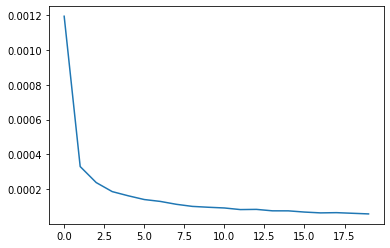

In [9]:
import matplotlib.pyplot as plt
train_plt = plt.plot(range(20),train_err,label='train')

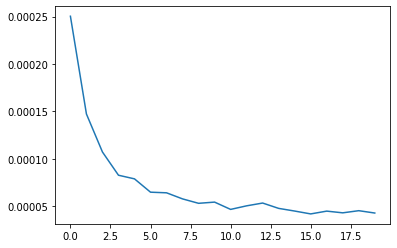

In [10]:
val_plt = plt.plot(range(20),val_err,label='val')

Both training errors and validation errors decrease with each epoch. The model reaches 99% validation accuracy with very few epochs. 

### Step 3: Show an image with the 32 5x5 filters that are estimated in the first layer of the model

In [0]:
for p in net.parameters():
  filters = p
  break

<function matplotlib.pyplot.show>

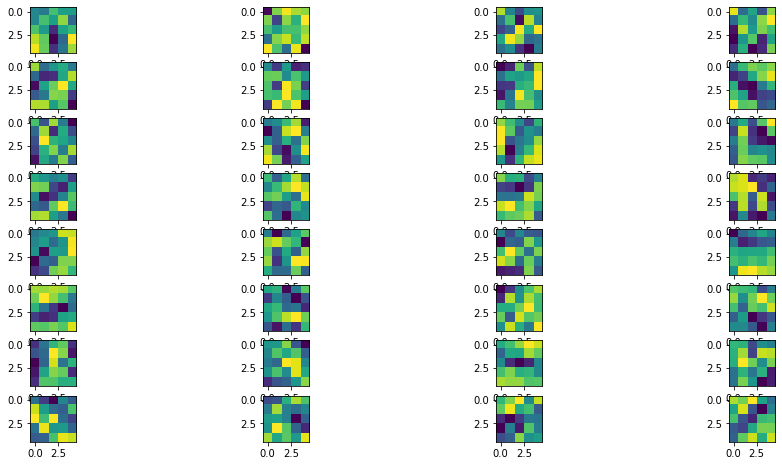

In [12]:
filters = filters.reshape([32,5,5])
plt.figure(figsize=(16,8))
nrows, ncols = [8,4]

for i in range(nrows):
  for j in range(ncols):
    plt.subplot(nrows,ncols,i*ncols+j+1)
    plt.imshow(filters[i*ncols+j].cpu().data.numpy())
plt.show

# (b)

## i.

### Step 1: Half the number of parameters while keeping the same number of layer

For approximately halving the number of parameters, I simply change the number of features in first layer to 16, and the number of features in second layer to 32, and adjust the parameters going into the fully connected layer accordingly. 

In [13]:
print('total number of parameters in the adjusted architecture is:',16*5*5+16*32*5*5+(512*256+256)+(256*10+10))

total number of parameters in the adjusted architecture is: 147098


In [0]:
class MNIST_Net(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net, self).__init__()
        # 16 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        # 32 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 32 x 4 x 4 = 512 units total in final spartial layer fully connected to 256 unit later
        self.fc1 = nn.Linear(512, 256)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(256, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
        self.first=True
        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 64 x 4 x 4 to 512 units
        x = x.view(-1, 512)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct

In [15]:
# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)

# Run epochs
train_err = []
val_err = []
for i in range(num_epochs):
    train_err.append(run_epoch(net,i,train,batch_size, num=numtrain, ttype="train"))
    # Test on validation set.
    val_err.append(net_test(net,val,batch_size))
# Test on test set.
net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+model_name)

cuda:0


  0%|          | 0/50000 [00:00<?, ?it/s]

(70000, 784)


  5%|▌         | 2500/50000 [00:00<00:01, 35810.31it/s, loss=0.211]


Training set epoch 0: Avg. loss: 0.0016, Accuracy: 37890/50000 (76%)


Validation set: Avg. loss: 0.0003, Accuracy: 9486/10000 (95%)



  6%|▌         | 3000/50000 [00:00<00:01, 37025.23it/s, loss=0.149]


Training set epoch 1: Avg. loss: 0.0004, Accuracy: 46828/50000 (94%)


Validation set: Avg. loss: 0.0002, Accuracy: 9715/10000 (97%)



  6%|▌         | 3000/50000 [00:00<00:01, 37747.64it/s, loss=0.0745]


Training set epoch 2: Avg. loss: 0.0003, Accuracy: 47785/50000 (96%)


Validation set: Avg. loss: 0.0001, Accuracy: 9792/10000 (98%)



  6%|▌         | 3000/50000 [00:00<00:01, 37190.58it/s, loss=0.0774]


Training set epoch 3: Avg. loss: 0.0002, Accuracy: 48188/50000 (96%)


Validation set: Avg. loss: 0.0001, Accuracy: 9834/10000 (98%)



  5%|▌         | 2500/50000 [00:00<00:01, 37105.26it/s, loss=0.118] 


Training set epoch 4: Avg. loss: 0.0002, Accuracy: 48435/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9854/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 37243.09it/s, loss=0.0368]


Training set epoch 5: Avg. loss: 0.0002, Accuracy: 48620/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9858/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 38467.15it/s, loss=0.0426]


Training set epoch 6: Avg. loss: 0.0002, Accuracy: 48676/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9882/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 35739.09it/s, loss=0.0431]


Training set epoch 7: Avg. loss: 0.0002, Accuracy: 48842/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9880/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 37182.75it/s, loss=0.0615]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 48956/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9892/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 37195.20it/s, loss=0.0286]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 48995/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9895/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 38239.66it/s, loss=0.0269]


Training set epoch 10: Avg. loss: 0.0001, Accuracy: 49046/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9898/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 37430.09it/s, loss=0.0226]


Training set epoch 11: Avg. loss: 0.0001, Accuracy: 49070/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9902/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 35793.32it/s, loss=0.0511]


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 49146/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9909/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 36873.54it/s, loss=0.0332]


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 49202/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9903/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 34852.97it/s, loss=0.048] 


Training set epoch 14: Avg. loss: 0.0001, Accuracy: 49222/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9912/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 37647.46it/s, loss=0.0275]


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 49229/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9906/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 38786.83it/s, loss=0.0184]


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 49266/50000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9903/10000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 38700.10it/s, loss=0.0132]


Training set epoch 17: Avg. loss: 0.0001, Accuracy: 49281/50000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9913/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 35275.54it/s, loss=0.0567]


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 49323/50000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9918/10000 (99%)



100%|██████████| 50000/50000 [00:01<00:00, 42779.53it/s, loss=0.0502]



Training set epoch 19: Avg. loss: 0.0001, Accuracy: 49317/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9924/10000 (99%)


Test set: Avg. loss: 0.0001, Accuracy: 9908/10000 (99%)



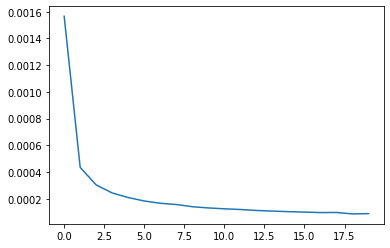

In [16]:
train_plt = plt.plot(range(20),train_err,label='train')

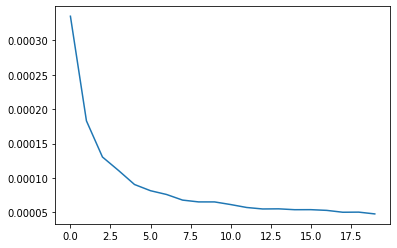

In [17]:
val_plt = plt.plot(range(20),val_err,label='val')

With half the number of parameters, training and validation loss still decreases to almost 0 as the number of epochs increases, but initially the error rate is higher. Still, the test accuracy is about the same at 99%. 

### Step 2: Double the number of parameters while keeping the same number of layer

To double the number of parameters, I simply double the number of features in the first layer to 64, keep the number of features in the second layer constant at 64, and then double the number of parameters in the second layer of the fully connected layer to 512. 

In [18]:
print('total number of parameters in the adjusted architecture is:',64*5*5+64*64*5*5+(1024*512+512)+(512*10+10))

total number of parameters in the adjusted architecture is: 633930


In [0]:
class MNIST_Net(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net, self).__init__()
        # 64 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 64 x 4 x 4 = 1024 units total in final spartial layer fully connected to 256 unit later
        self.fc1 = nn.Linear(1024, 256)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(256, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
        self.first=True
        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 64 x 4 x 4 to 1024 units
        x = x.view(-1, 1024)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct

In [20]:
# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)

# Run epochs
train_err = []
val_err = []
for i in range(num_epochs):
    train_err.append(run_epoch(net,i,train,batch_size, num=numtrain, ttype="train"))
    # Test on validation set.
    val_err.append(net_test(net,val,batch_size))
# Test on test set.
net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+model_name)

cuda:0
(70000, 784)


  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0010, Accuracy: 42294/50000 (85%)


Validation set: Avg. loss: 0.0002, Accuracy: 9658/10000 (97%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0003, Accuracy: 47866/50000 (96%)


Validation set: Avg. loss: 0.0001, Accuracy: 9811/10000 (98%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0002, Accuracy: 48406/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9847/10000 (98%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0002, Accuracy: 48745/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9879/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 48888/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9892/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 49043/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9900/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0001, Accuracy: 49139/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9904/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0001, Accuracy: 49247/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9910/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 49283/50000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9908/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 49338/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9921/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0001, Accuracy: 49343/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9923/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0001, Accuracy: 49383/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9921/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 49422/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9922/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 49466/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9929/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0001, Accuracy: 49481/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9936/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 49495/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9939/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 49517/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9931/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0001, Accuracy: 49523/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9930/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 49594/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9942/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 16639.28it/s, loss=0.025]



Training set epoch 19: Avg. loss: 0.0001, Accuracy: 49560/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9943/10000 (99%)


Test set: Avg. loss: 0.0001, Accuracy: 9925/10000 (99%)



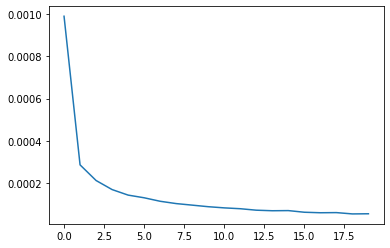

In [21]:
train_plt = plt.plot(range(20),train_err,label='train')

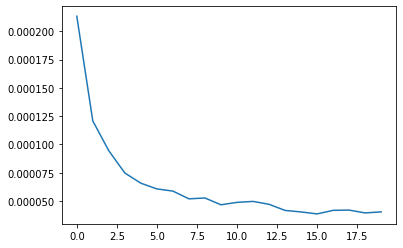

In [22]:
val_plt = plt.plot(range(20),val_err,label='val')

The rate of convergence is pretty similar to the original architecture. We see that because of the increased number of parameters, the training error converges even faster than the original architecture. The test accuracy is still at 99%. 


### ii. Design a deeper network with more or less the same number of parameters as the original network

I use the following architecture:
*   First layer: 32 features with 5x5 kernel and no padding 
*   Second layer: 64 features with 5x5 kernel and padding
*   Third layer: 70 features with 5x5 kernel and padding
*   Fully connected first layer: going from 630 features to 240 features 

In [23]:
print('total number of parameters in the adjusted architecture is:',32*5*5+32*64*5*5+64*70*5*5+(630*240+240)+(240*10+10))

total number of parameters in the adjusted architecture is: 317850


In [0]:
class MNIST_Net(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net, self).__init__()
        # 16 output features using 5x5 kernel applied to input image, without padding
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5,padding=2)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv3 = nn.Conv2d(64,70,kernel_size=5,padding=2)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv3_drop = nn.Dropout2d(p)
        # 70 x 3 x 3 = 630 units total in final spartial layer fully connected to 240 unit later
        self.fc1 = nn.Linear(630, 240)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(240, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
        self.first=True
        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Apply third conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        # Reshape 64 x 4 x 4 to 630 units
        x = x.view(-1, 630)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct

In [25]:
# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)

# Run epochs
train_err = []
val_err = []
for i in range(num_epochs):
    train_err.append(run_epoch(net,i,train,batch_size, num=numtrain, ttype="train"))
    # Test on validation set.
    val_err.append(net_test(net,val,batch_size))
# Test on test set.
net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+model_name)

cuda:0
(70000, 784)


100%|██████████| 50000/50000 [00:03<00:00, 13720.27it/s, loss=0.198]



Training set epoch 0: Avg. loss: 0.0012, Accuracy: 40498/50000 (81%)



  3%|▎         | 1500/50000 [00:00<00:03, 13708.28it/s, loss=0.135]


Validation set: Avg. loss: 0.0002, Accuracy: 9702/10000 (97%)



100%|██████████| 50000/50000 [00:03<00:00, 13758.29it/s, loss=0.152]



Training set epoch 1: Avg. loss: 0.0003, Accuracy: 48018/50000 (96%)



  3%|▎         | 1500/50000 [00:00<00:03, 13738.21it/s, loss=0.0674]


Validation set: Avg. loss: 0.0001, Accuracy: 9823/10000 (98%)



100%|██████████| 50000/50000 [00:03<00:00, 13735.44it/s, loss=0.0837]



Training set epoch 2: Avg. loss: 0.0002, Accuracy: 48671/50000 (97%)



  3%|▎         | 1500/50000 [00:00<00:03, 13655.79it/s, loss=0.0579]


Validation set: Avg. loss: 0.0001, Accuracy: 9870/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13717.67it/s, loss=0.108]



Training set epoch 3: Avg. loss: 0.0001, Accuracy: 48877/50000 (98%)



  3%|▎         | 1500/50000 [00:00<00:03, 13823.18it/s, loss=0.0551]


Validation set: Avg. loss: 0.0001, Accuracy: 9879/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13790.12it/s, loss=0.0573]



Training set epoch 4: Avg. loss: 0.0001, Accuracy: 49144/50000 (98%)



  3%|▎         | 1500/50000 [00:00<00:03, 13724.10it/s, loss=0.0421]


Validation set: Avg. loss: 0.0001, Accuracy: 9892/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13789.97it/s, loss=0.0608]



Training set epoch 5: Avg. loss: 0.0001, Accuracy: 49235/50000 (98%)



  3%|▎         | 1500/50000 [00:00<00:03, 13971.85it/s, loss=0.0472]


Validation set: Avg. loss: 0.0001, Accuracy: 9901/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13876.75it/s, loss=0.0353]



Training set epoch 6: Avg. loss: 0.0001, Accuracy: 49377/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13605.21it/s, loss=0.035] 


Validation set: Avg. loss: 0.0000, Accuracy: 9917/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13767.97it/s, loss=0.0624]



Training set epoch 7: Avg. loss: 0.0001, Accuracy: 49447/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13550.44it/s, loss=0.0327]


Validation set: Avg. loss: 0.0000, Accuracy: 9922/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13760.38it/s, loss=0.0432]



Training set epoch 8: Avg. loss: 0.0001, Accuracy: 49512/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 14030.46it/s, loss=0.0349]


Validation set: Avg. loss: 0.0000, Accuracy: 9924/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13718.26it/s, loss=0.0345]



Training set epoch 9: Avg. loss: 0.0001, Accuracy: 49521/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13581.48it/s, loss=0.0339]


Validation set: Avg. loss: 0.0000, Accuracy: 9933/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13739.83it/s, loss=0.0382]



Training set epoch 10: Avg. loss: 0.0001, Accuracy: 49593/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13887.57it/s, loss=0.0124]


Validation set: Avg. loss: 0.0000, Accuracy: 9939/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13786.19it/s, loss=0.0156]



Training set epoch 11: Avg. loss: 0.0000, Accuracy: 49594/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13713.03it/s, loss=0.0322]


Validation set: Avg. loss: 0.0000, Accuracy: 9934/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13782.75it/s, loss=0.0455]



Training set epoch 12: Avg. loss: 0.0000, Accuracy: 49646/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13423.52it/s, loss=0.0151]


Validation set: Avg. loss: 0.0000, Accuracy: 9935/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13684.41it/s, loss=0.0265]



Training set epoch 13: Avg. loss: 0.0000, Accuracy: 49693/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13721.52it/s, loss=0.0253]


Validation set: Avg. loss: 0.0000, Accuracy: 9940/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13737.45it/s, loss=0.0213]



Training set epoch 14: Avg. loss: 0.0000, Accuracy: 49697/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13434.10it/s, loss=0.0174]


Validation set: Avg. loss: 0.0000, Accuracy: 9942/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13773.03it/s, loss=0.0116]



Training set epoch 15: Avg. loss: 0.0000, Accuracy: 49720/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13846.79it/s, loss=0.00446]


Validation set: Avg. loss: 0.0000, Accuracy: 9941/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13734.60it/s, loss=0.00483]



Training set epoch 16: Avg. loss: 0.0000, Accuracy: 49766/50000 (100%)



  3%|▎         | 1500/50000 [00:00<00:03, 13785.11it/s, loss=0.00656]


Validation set: Avg. loss: 0.0000, Accuracy: 9932/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13869.65it/s, loss=0.0106]



Training set epoch 17: Avg. loss: 0.0000, Accuracy: 49723/50000 (99%)



  3%|▎         | 1500/50000 [00:00<00:03, 13836.89it/s, loss=0.0124]


Validation set: Avg. loss: 0.0000, Accuracy: 9935/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13779.39it/s, loss=0.0233]



Training set epoch 18: Avg. loss: 0.0000, Accuracy: 49769/50000 (100%)



  3%|▎         | 1500/50000 [00:00<00:03, 14066.92it/s, loss=0.0179] 


Validation set: Avg. loss: 0.0000, Accuracy: 9942/10000 (99%)



100%|██████████| 50000/50000 [00:03<00:00, 13671.14it/s, loss=0.0405]



Training set epoch 19: Avg. loss: 0.0000, Accuracy: 49769/50000 (100%)


Validation set: Avg. loss: 0.0000, Accuracy: 9938/10000 (99%)


Test set: Avg. loss: 0.0001, Accuracy: 9928/10000 (99%)



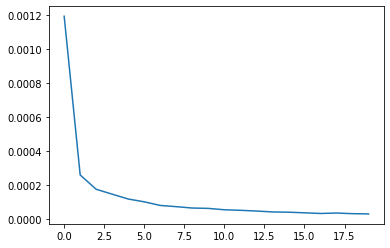

In [26]:
train_plt = plt.plot(range(20),train_err,label='train')

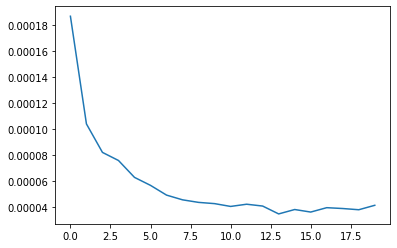

In [27]:
val_plt = plt.plot(range(20),val_err,label='val')

Again, the differences are minimal and we still get 99% accuracy for test set.

### iii.Try on full training set and report the result

Having more parameters or a deeper network does not seem to bring significant difference to the error rate which is already very low. Having fewer parameters seem to make the error rate drop slower, while having deeper network makes the training process take longer. We prefer to have fewer parameters to avoid overfitting, so I will just go with the default setting of the original model and train it on the full training set, which is the augmented data set constituting the original training data and validation data. 

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net, self).__init__()
        # 32 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 64 x 4 x 4 = 1024 units total in final spartial layer fully connected to 256 unit later
        self.fc1 = nn.Linear(1024, 256)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(256, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
        self.first=True
        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 64 x 4 x 4 to 1024 units
        x = x.view(-1, 1024)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

In [29]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=50000
minimizer="Adam"
data_set="mnist"
model_name="model"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get augmented data
train,val,test=get_data(data_set=data_set)
train = list(train)
train[0] = np.concatenate((train[0],val[0]),axis=0)
train[1] = np.concatenate((train[1],val[1]),axis=0)
train = tuple(train)
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_err = []
val_err = []
for i in range(num_epochs):
    train_err.append(run_epoch(net,i,train,batch_size, num=numtrain, ttype="train"))
# Test on test set.
net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+model_name)

cuda:0
(70000, 784)


  6%|▌         | 3000/50000 [00:00<00:01, 24127.10it/s, loss=0.146]


Training set epoch 0: Avg. loss: 0.0011, Accuracy: 41404/50000 (83%)



  6%|▌         | 3000/50000 [00:00<00:01, 24322.02it/s, loss=0.0668]


Training set epoch 1: Avg. loss: 0.0003, Accuracy: 47771/50000 (96%)



  6%|▌         | 3000/50000 [00:00<00:01, 24463.83it/s, loss=0.058]


Training set epoch 2: Avg. loss: 0.0002, Accuracy: 48344/50000 (97%)



  6%|▌         | 3000/50000 [00:00<00:02, 23460.49it/s, loss=0.0552]


Training set epoch 3: Avg. loss: 0.0002, Accuracy: 48653/50000 (97%)



  6%|▌         | 3000/50000 [00:00<00:02, 23181.97it/s, loss=0.0553]


Training set epoch 4: Avg. loss: 0.0002, Accuracy: 48812/50000 (98%)



  6%|▌         | 3000/50000 [00:00<00:01, 23967.51it/s, loss=0.0389]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 48989/50000 (98%)



  6%|▌         | 3000/50000 [00:00<00:02, 23393.18it/s, loss=0.0374]


Training set epoch 6: Avg. loss: 0.0001, Accuracy: 49081/50000 (98%)



  6%|▌         | 3000/50000 [00:00<00:01, 24344.73it/s, loss=0.0373]


Training set epoch 7: Avg. loss: 0.0001, Accuracy: 49142/50000 (98%)



  6%|▌         | 3000/50000 [00:00<00:01, 24179.79it/s, loss=0.0275]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 49225/50000 (98%)



  6%|▌         | 3000/50000 [00:00<00:01, 24603.08it/s, loss=0.0179]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 49273/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 23574.79it/s, loss=0.0333]


Training set epoch 10: Avg. loss: 0.0001, Accuracy: 49340/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 24440.56it/s, loss=0.029] 


Training set epoch 11: Avg. loss: 0.0001, Accuracy: 49338/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 24117.50it/s, loss=0.0172]


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 49427/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 23533.63it/s, loss=0.0199]


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 49412/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 24303.03it/s, loss=0.0124]


Training set epoch 14: Avg. loss: 0.0001, Accuracy: 49429/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 24980.25it/s, loss=0.0258]


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 49449/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 24411.55it/s, loss=0.0225]


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 49455/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 24521.10it/s, loss=0.017] 


Training set epoch 17: Avg. loss: 0.0001, Accuracy: 49493/50000 (99%)



  6%|▌         | 3000/50000 [00:00<00:01, 24341.73it/s, loss=0.0177]


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 49521/50000 (99%)



100%|██████████| 50000/50000 [00:02<00:00, 23681.26it/s, loss=0.0309]



Training set epoch 19: Avg. loss: 0.0001, Accuracy: 49540/50000 (99%)


Test set: Avg. loss: 0.0001, Accuracy: 9917/10000 (99%)



Since model using fraction of training set already achieves 99% test accuracy, using the full data set still get 99% accuracy. 

# (C)

### Step 1: Display few examples of transformed data alongside the original digits

In [0]:
def get_mnist_transformed():
    data=np.float64(np.load(datadir+'mnist/MNIST_TR.npy'))
    labels=np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:50000])
    val_dat=data[50000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[50000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    if (data_set=='trans'):
      return(get_mnist_transformed())

In [31]:
train,val,test=get_data(data_set="mnist")
train_tr,val_tr,test_tr=get_data(data_set="trans")

(70000, 784)
(70000, 1, 28, 28)


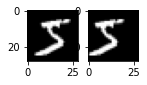

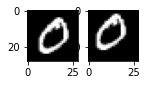

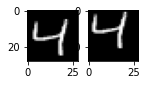

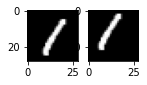

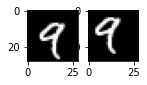

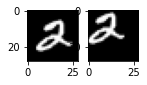

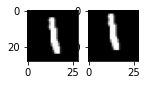

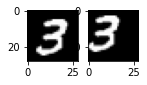

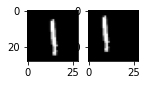

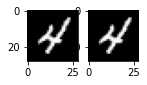

In [32]:
for i in range(10):
  original = train[0][i,0,:,:]
  trans = train_tr[0][i,0,:,:]
  plt.figure(figsize=(2,4))
  plt.subplot(1,2,1)
  plt.imshow(original,cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(trans,cmap='gray')

### Step 2: Using the original architecture to test on this data set

In [33]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=50000
minimizer="Adam"
data_set="mnist"
model_name="model"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set="mnist")
train_tr,val_tr,test_tr=get_data(data_set="trans")
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_err = []
val_err = []
for i in range(num_epochs):
    train_err.append(run_epoch(net,i,train,batch_size, num=numtrain, ttype="train"))
    # Test on validation set.
    val_err.append(net_test(net,val,batch_size))
# Test on test set.
net_test(net,test_tr,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+model_name)

cuda:0
(70000, 784)


  0%|          | 0/50000 [00:00<?, ?it/s, loss=2.31]

(70000, 1, 28, 28)


  2%|▏         | 1000/50000 [00:00<00:02, 17138.92it/s, loss=0.267]


Training set epoch 0: Avg. loss: 0.0012, Accuracy: 40309/50000 (81%)


Validation set: Avg. loss: 0.0003, Accuracy: 9607/10000 (96%)



  1%|          | 500/50000 [00:00<00:04, 11237.55it/s, loss=0.156]


Training set epoch 1: Avg. loss: 0.0003, Accuracy: 47564/50000 (95%)


Validation set: Avg. loss: 0.0001, Accuracy: 9803/10000 (98%)



  2%|▏         | 1000/50000 [00:00<00:02, 16872.99it/s, loss=0.127]


Training set epoch 2: Avg. loss: 0.0002, Accuracy: 48351/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9836/10000 (98%)



  1%|          | 500/50000 [00:00<00:04, 11696.59it/s, loss=0.0868]


Training set epoch 3: Avg. loss: 0.0002, Accuracy: 48675/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9880/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16932.73it/s, loss=0.0879]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 48855/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9898/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16455.16it/s, loss=0.0775]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 48986/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9909/10000 (99%)



  1%|          | 500/50000 [00:00<00:04, 12168.69it/s, loss=0.0584]


Training set epoch 6: Avg. loss: 0.0001, Accuracy: 49058/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9911/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16336.27it/s, loss=0.0477]


Training set epoch 7: Avg. loss: 0.0001, Accuracy: 49172/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9917/10000 (99%)



  1%|          | 500/50000 [00:00<00:04, 11627.33it/s, loss=0.0501]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 49217/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9925/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12392.76it/s, loss=0.0484]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 49285/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9928/10000 (99%)



  1%|          | 500/50000 [00:00<00:04, 12241.85it/s, loss=0.038]


Training set epoch 10: Avg. loss: 0.0001, Accuracy: 49341/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9923/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 13018.59it/s, loss=0.0383]


Training set epoch 11: Avg. loss: 0.0001, Accuracy: 49332/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9929/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12585.00it/s, loss=0.0505]


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 49383/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9927/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16529.73it/s, loss=0.0315]


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 49428/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9932/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12588.17it/s, loss=0.0377]


Training set epoch 14: Avg. loss: 0.0001, Accuracy: 49450/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9941/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12552.69it/s, loss=0.0489]


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 49480/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9932/10000 (99%)



  1%|          | 500/50000 [00:00<00:03, 12549.15it/s, loss=0.0282]


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 49498/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9930/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:03, 16113.22it/s, loss=0.0206]


Training set epoch 17: Avg. loss: 0.0001, Accuracy: 49536/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9929/10000 (99%)



  2%|▏         | 1000/50000 [00:00<00:02, 16464.46it/s, loss=0.0265]


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 49505/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9931/10000 (99%)



100%|██████████| 50000/50000 [00:02<00:00, 23743.33it/s, loss=0.0233]



Training set epoch 19: Avg. loss: 0.0001, Accuracy: 49576/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9935/10000 (99%)


Test set: Avg. loss: 0.0060, Accuracy: 5644/10000 (56%)



The test error is now significantly lower, at only 54%.

### Step 3: Propose changes to the network architecture 

From the results we see that the neural network is currently sensitive to local variations. To mitigate this I propose to increase the extent of pooling that occurs at each layer. In particular, I will increase the extent pooling from 2 to 3.  To make pooling work, I will also adjust the kernel size to 3 at the second layer. To balance out the drop in parameter due to increase in pooling, I will increase the number of features at each layer. 

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net, self).__init__()
        # 32 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 64 x 4 x 4 = 1024 units total in final spartial layer fully connected to 256 unit later
        self.fc1 = nn.Linear(512, 256)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(256, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
        self.first=True
        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 3))
        # Reshape 64 x 2 x 2 to 256 units
        x = x.view(-1, 512)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
   

In [35]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=50000
minimizer="Adam"
data_set="mnist"
model_name="model"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set="mnist")
train_tr,val_tr,test_tr=get_data(data_set="trans")
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_err = []
val_err = []
for i in range(num_epochs):
    train_err.append(run_epoch(net,i,train,batch_size, num=numtrain, ttype="train"))
    # Test on validation set.
    val_err.append(net_test(net,val,batch_size))
# Test on test set.
net_test(net,test_tr,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+model_name)

cuda:0
(70000, 784)


  1%|          | 500/50000 [00:00<00:04, 11529.85it/s, loss=2.3]

(70000, 1, 28, 28)


  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.179]


Training set epoch 0: Avg. loss: 0.0015, Accuracy: 38404/50000 (77%)


Validation set: Avg. loss: 0.0002, Accuracy: 9678/10000 (97%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.139]


Training set epoch 1: Avg. loss: 0.0003, Accuracy: 47427/50000 (95%)


Validation set: Avg. loss: 0.0001, Accuracy: 9780/10000 (98%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.103]


Training set epoch 2: Avg. loss: 0.0003, Accuracy: 48114/50000 (96%)


Validation set: Avg. loss: 0.0001, Accuracy: 9828/10000 (98%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0945]


Training set epoch 3: Avg. loss: 0.0002, Accuracy: 48471/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9857/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0982]


Training set epoch 4: Avg. loss: 0.0002, Accuracy: 48682/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9870/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0843]


Training set epoch 5: Avg. loss: 0.0002, Accuracy: 48847/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9896/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0641]


Training set epoch 6: Avg. loss: 0.0001, Accuracy: 49021/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9900/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.075]


Training set epoch 7: Avg. loss: 0.0001, Accuracy: 49033/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9893/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0536]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 49111/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9907/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0599]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 49213/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9919/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0509]


Training set epoch 10: Avg. loss: 0.0001, Accuracy: 49249/50000 (98%)


Validation set: Avg. loss: 0.0000, Accuracy: 9924/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.047]


Training set epoch 11: Avg. loss: 0.0001, Accuracy: 49265/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9925/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0426]


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 49311/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9930/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0465]


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 49346/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9932/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0597]


Training set epoch 14: Avg. loss: 0.0001, Accuracy: 49381/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9933/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.041]


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 49392/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9932/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0432]


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 49421/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9937/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0346]


Training set epoch 17: Avg. loss: 0.0001, Accuracy: 49490/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9937/10000 (99%)



  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0351]


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 49443/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9940/10000 (99%)



100%|██████████| 50000/50000 [00:02<00:00, 22269.29it/s, loss=0.0437]



Training set epoch 19: Avg. loss: 0.0001, Accuracy: 49501/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9943/10000 (99%)


Test set: Avg. loss: 0.0028, Accuracy: 7229/10000 (72%)



We see that with pooling, now the test error has improved from 54% to 70%. A deeper neural network with more fine tuned number of features could improve this error rate further. 